## [EXAM ATTACHED / EXAMEN CI-JOINT] Stream 1: Machine Learning - Selection Process Number: 22-STC-IA-NCR-314-135
Submitted by **MOSES OLAYINKA OYEDELE**

Email: **deleolayinka@gmail.com**

Assignment 2: **Natural Language Processing with Disaster Tweets**

Dataset: **Kaggle Natural Disasters Dataset**

## Dataset
This data set was produced by the company figure-eight and was first made available on their "Data for Everyone" [website](https://appen.com/pre-labeled-datasets/).

### Files
**sample_submission.csv** - a sample submission file in the correct format

**train.csv** - the training set

**test.csv** - the test set


### Columns
**id** - a unique identifier for each tweet

**text** - the text of the tweet

**location** - the location the tweet was sent from (may be blank)

**keyword** - a particular keyword from the tweet (may be blank)

**target** - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

## Solution

We'll follow a step-by-step procedure to determine whether a specific Tweet refers to an actual disaster or not before making our forecasts.

Let's get going by importing the necessary packages and libraries!

In [1]:
# Import packages and use aliases for code brevity
# Data Manipulation Packages
import pandas as pd
import numpy as np
from collections import Counter
from time import time

# Data Visualization Packages
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# Data/Text Cleaning Packages
from wordcloud import WordCloud
import re, string 
import nltk
from nltk.corpus import stopwords
import nltk.data
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from tensorflow.keras.optimizers import Adam

# Machine Learning Packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#Import metric for performance evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

from warnings import filterwarnings # This enables better control of warning messages
filterwarnings ('ignore')

### Exploratory Data Analysis ⚒️

In [2]:
# Load Datasets
sample_df = pd.read_csv('sample_submission.csv')
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Set how many characters to show in the dataframe cell
pd.set_option('display.max_colwidth', 150)

In [3]:
# Show a sample of observations for the sample submission dataset
sample_df.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [4]:
# Check the size, shape, and the number duplicated & missing values of the sample submission Dataset
print('\033[1m' + 'SAMPLE SUBMISSION DATASET' + '\033[0m')
print('\033[1m' + 'Size: ' + '\033[0m' + str(sample_df.size))
print('\033[1m' + 'Shape: ' + '\033[0m' + str(sample_df.shape))
print('\033[1m' + 'Duplicated Values: ' + '\033[0m' + str(sample_df.duplicated().sum()))
print('\033[1m' + 'Missing Values: ' + '\033[0m')
print(str(sample_df.isnull().sum()))

SAMPLE SUBMISSION DATASET
Size: 6526
Shape: (3263, 2)
Duplicated Values: 0
Missing Values: 
id        0
target    0
dtype: int64


<div class="alert alert-block alert-info">
<ul>
    <li>There are no <b>duplicated</b> or <b>missing values</b> in the sample submission dataset.</li>
</ul>
    </div>

In [5]:
# Show a sample of observations for the training dataset
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [6]:
# Check the size, shape, and the number duplicated & missing values of the training Dataset
print('\033[1m' + 'TRAINING DATASET' + '\033[0m')
print('\033[1m' + 'Size: ' + '\033[0m' + str(train_df.size))
print('\033[1m' + 'Shape: ' + '\033[0m' + str(train_df.shape))
print('\033[1m' + 'Duplicated Values: ' + '\033[0m' + str(train_df.duplicated().sum()))
print('\033[1m' + 'Missing Values: ' + '\033[0m')
print(str(train_df.isnull().sum()))

TRAINING DATASET
Size: 38065
Shape: (7613, 5)
Duplicated Values: 0
Missing Values: 
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


<div class="alert alert-block alert-info">
<ul>
    <li>In the training dataset, there are <b>61 and 2,533 missing observations</b> in the <b>keyword</b> and <b>location</b> variables respectively. However, there are no duplicate values in the dataset.</li>
</ul>
    </div>

In [7]:
# Show a sample of observations for the testing dataset
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# Check the size, shape, and the number duplicated & missing values of the testing Dataset
print('\033[1m' + 'TESTING DATASET' + '\033[0m')
print('\033[1m' + 'Size: ' + '\033[0m' + str(test_df.size))
print('\033[1m' + 'Shape: ' + '\033[0m' + str(test_df.shape))
print('\033[1m' + 'Duplicated Values: ' + '\033[0m' + str(test_df.duplicated().sum()))
print('\033[1m' + 'Missing Values: ' + '\033[0m')
print(str(test_df.isnull().sum()))

TESTING DATASET
Size: 13052
Shape: (3263, 4)
Duplicated Values: 0
Missing Values: 
id             0
keyword       26
location    1105
text           0
dtype: int64


<div class="alert alert-block alert-info">
<ul>
    <li>In the testing dataset, there are <b>26 and 1,105 missing observations</b> in the <b>keyword</b> and <b>location</b> variables respectively. However, there are also no duplicate values in the dataset.</li>
</ul>
    </div>

In [9]:
# Count the distinct attributes in the target column and compute their percentages
train_df_count = train_df['target'].value_counts()
train_df_percentage = train_df_count/sum(train_df_count)*100
train_df_count_df = pd.DataFrame(train_df_count.items(), columns = ['Target','Count'])
train_df_percentage_df = pd.DataFrame(train_df_percentage.items(), columns = ['Target','Percentage'])
train_df_summary = pd.merge(train_df_count_df, train_df_percentage_df, on = 'Target', how = 'left')
train_df_summary

,Target,Count,Percentage
0,0,4342,57.034021
1,1,3271,42.965979


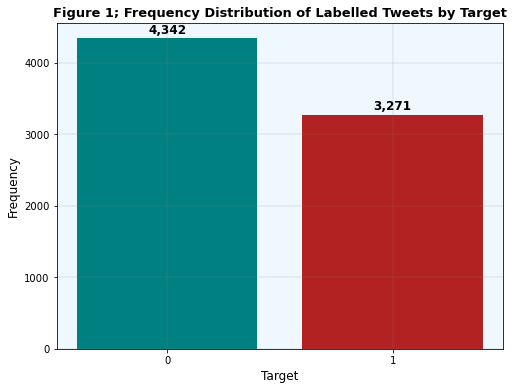

In [10]:
# Create a % barplot distribution of the Class variable the figure size, theme, title, and axis labels
bar, ax = plt.subplots(figsize = [8,6])
colors = ['teal', 'firebrick']
ax.set_facecolor('aliceblue')
train_df_summary['Target'] = train_df_summary['Target'].apply(str)
ax.bar(train_df_summary['Target'], train_df_summary['Count'], align='center', color = colors, alpha = 1.0)
ax.set_xlabel('Target', fontsize = 12)
ax.set_ylabel('Frequency', fontsize = 12)

# Add some text for the labels, title, and custom x-axis tick labels, etc.
ax.bar_label(ax.containers[0], padding = 2, weight = 'bold', fontsize = 12, color = 'black', 
             labels=[f'{x:,.0f}' for x in ax.containers[0].datavalues])
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
plt.title('Figure 1; Frequency Distribution of Labelled Tweets by Target', fontsize = 13, weight = 'bold')
plt.grid(color='grey', linestyle='-', linewidth=0.2)
plt.show();

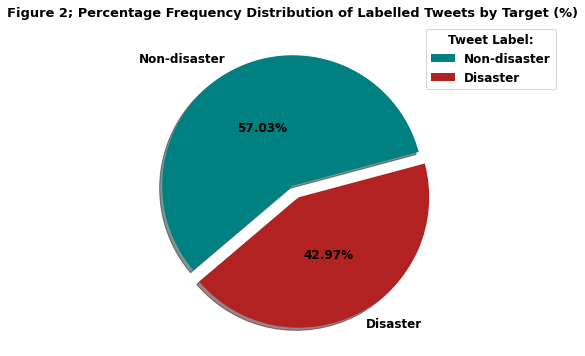

In [11]:
# Evaluate the distribution(imbalance) of the training dataset using a pie chart
# Create a pie-chart distribution of the target attributes setting the figure size, legend, title, and axis labels
pie, ax = plt.subplots(figsize = [8,6])
size = train_df['target'].value_counts()
labels = ['Non-disaster', 'Disaster']
colors = ['teal', 'firebrick']
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.pie(x = size, autopct = '%1.2f%%', explode = [0, 0.1], labels = labels, colors = colors, pctdistance = 0.5, 
        shadow = True, startangle = 15, textprops = dict(color = 'black'))
plt.title('Figure 2; Percentage Frequency Distribution of Labelled Tweets by Target (%)', fontsize = 13, weight = 'bold')
plt.legend(title = 'Tweet Label:', loc = 'best', bbox_to_anchor =(0.89, 1.0))
plt.show();

<div class="alert alert-block alert-success">
    Since the training dataset is <b>evenly distributed</b>, accuracy would not be an inadequate criterion to gauge the effectiveness of our classification models.
    </div>

In [12]:
# Evaluate the text count distribution of the training dataset using a histogram
# Create a line-plot distribution of the target attributes in relation to the text count
# setting the figure size, legend, title, and axis labels
train_df['text_len'] = train_df['text'].apply(lambda x: len(x.split(' ')))
disaster_df = train_df[train_df['target'] == 1]['text_len'].value_counts().sort_index()
non_disaster_df = train_df[train_df['target'] == 0]['text_len'].value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=disaster_df.index,
    y=disaster_df.values,
    name='Disaster',
    fill='tozeroy',
    marker_color='#496595',
))
fig.add_trace(go.Scatter(
    x=non_disaster_df.index,
    y=non_disaster_df.values,
    name='Non-disaster',
    fill='tozeroy',
    marker_color='#c6ccd8',
))
fig.update_layout(
    title='<span style="font-size:16px; font-family:Times New Roman"><b>Figure 3: Distribution of Message length by Tweet Label</b></span>'
)
fig.update_xaxes(range=[0, 70])
fig.show();

<div class="alert alert-block alert-info">
    As observed, there is <b>no significant difference</b> between the text count of disaster and non-disaster tweets.
        </div>

### Word Clouds Using Unprocessed Text
Consider the raw text as a word cloud. The text size displays how frequently a word appears in the dataset.

In [13]:
# Create a word cloud for disaster and non-disaster tweets
# Set the random state
random_state = 42

# Concatenate all the text for each label
non_disaster_text = [''.join(t) for t in train_df[train_df['target']==0]['text']]
non_disaster_strings = ' '.join(map(str, non_disaster_text))
disaster_text = [''.join(t) for t in train_df[train_df['target']==1]['text']]
disaster_strings = ' '.join(map(str, disaster_text))

# Generate word clouds
non_disaster_cloud = WordCloud(width = 800, height = 400, max_words = 500, background_color = 'white', 
                               random_state = random_state).generate(non_disaster_strings)
disaster_cloud = WordCloud(width = 800, height = 400, max_words = 500, 
                           random_state = random_state).generate(disaster_strings)

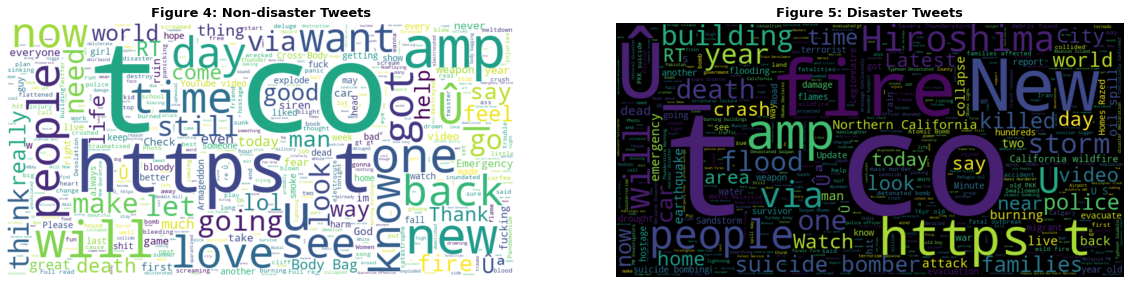

In [14]:
# Create subplots for the generated clouds
fig, axes = plt.subplots(1, 2, figsize = (20,20))
axes[0].imshow(non_disaster_cloud, interpolation = 'bilinear')
axes[1].imshow(disaster_cloud, interpolation = 'bilinear')

# Turn the axis off
[ax.axis('off') for ax in axes]

# Add titles
axes[0].set_title('Figure 4: Non-disaster Tweets', fontsize = 13, weight = 'bold')
axes[1].set_title('Figure 5: Disaster Tweets', fontsize = 13, weight = 'bold')

# Show the figure
plt.show();

<div class="alert alert-block alert-info">
    Some words associated with disasters, such <b>'fire', 'crash', 'flood', and 'death'</b> are easily recognisable, but it can be difficult to distinguish between tweets about disasters and those not related to them. The clouds are dominated by letters like <b>'t' and 'co'</b>, which stand for shortened links on Twitter, but they don't really imply anything. We'll examine these afterwards with word clouds created using preprocessed data.
    </div>

## TASK 1 - Bag of words model 🧳

- The Bag of Words model is a simple idea that entails converting text into a vector form that includes the frequency of each word in the sentence. By constructing a vector, we create an independent feature for our model that will be dependent on the categorization of the text (1 or 0). Any algorithm can be used to train the model. However, because it overlooks the semantic content of the text, this approach is usually less effective.

To proceed, we first create a new dataframe capturing just the tweets (text).

In [15]:
# Create a new dataframe with just the tweets and target variables
words_df = train_df.drop(['location','keyword', 'text_len'], axis=1)
words_df.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,"13,000 people receive #wildfires evacuation orders in California",1
4,7,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


### Pre-processing Dataset

In [16]:
# Define a function to remove punctuations, and non-emglish words
stopwords.words('english');
def message_cleaning(message):
    test_punc_removed = [char for char in message if char not in string.punctuation]
    test_punc_removed_joined = ''.join(test_punc_removed)
    test_punc_removed_joined_clean = [word for word in test_punc_removed_joined.split(' ') if word not in stopwords.words('english')]
    return test_punc_removed_joined_clean

In [17]:
# Vectorize the text
vectorizer = CountVectorizer(analyzer = message_cleaning)

- By eliminating punctuation and countwords, we're going to vectorize the text and make it easier to read.

In [18]:
# Vectorize the tweets containing the text 'disaster'
disaster_tweet_vectorizer = vectorizer.fit_transform(words_df['text'])
vectorizer.get_feature_names();
print(disaster_tweet_vectorizer.toarray())
print('\n')
print('\033[1m' + 'Disaster Tweet Vectorizer Shape: ' + '\033[0m' + str(disaster_tweet_vectorizer.shape))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


Disaster Tweet Vectorizer Shape: (7613, 26918)


<div class="alert alert-block alert-info">This matrix displays the number of distinct words in each sentence as displayed in the preceding cell output. There are thus <b>7,613</b> tweets about disasters and <b>21,637</b> different words.
    </div>

### Training the model

In [19]:
# Defining the model variables
label = words_df['target']
y = label
X = disaster_tweet_vectorizer
X = X.toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [20]:
# Split the cleaned and transformed dataset into training and testing sets using the 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

<div class="alert alert-block alert-info">
    The study opted to use the <b>Logistic Regression classification model</b> due to the dichotomous (binary) nature of the target variable <b>(Class)</b>. Logistic Regression is one of the most simple and commonly used Machine Learning algorithms for two-class classifications. It uses a log of odds as the dependent variable, and predicts the probability of occurrence of a binary event utilizing a logit function.
    <div>

In [21]:
# Defining the modelling function
def modeling(alg, alg_name, params={}):
    model = alg(**params) # Instantiating the algorithm class and unpacking parameters if any
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Performance evaluation
    def print_scores(alg, y_true, y_pred):
        print('\033[1m' + alg_name + '\033[0m')
        acc_score = accuracy_score(y_true, y_pred)
        print("accuracy: ",acc_score)
        pre_score = precision_score(y_true, y_pred)
        print("precision: ",pre_score)
        rec_score = recall_score(y_true, y_pred)                            
        print("recall: ",rec_score)
        f_score = f1_score(y_true, y_pred, average='weighted')
        print("f1_score: ",f_score)

    print_scores(alg, y_test, y_pred)
    return model

# Applying logistic regression model as the base model
log_model = modeling(LogisticRegression, 'Logistic Regression')

Logistic Regression
accuracy:  0.7957977675640184
precision:  0.8083941605839416
recall:  0.6825885978428351
f1_score:  0.7927599030699063


- The logistic regression model predicts the class of tweets with an **accuracy** of **79.58%**. This may be considered a fair accuracy score considering the stochastic nature of the modelling algorithm.
 - The model accurately predicts accurate disaster tweets **80.84%** of the time based on the **Precision score**.
 - The model correctly identifies observations of a certain class correctly from all of the given examples of that class **68.26%** of the time based on the **Recall score**..
 - If there are positive observations in the test set, the classification model can identify them **79.28%** of the time based on the **F1-Score**.

<div class="alert alert-block alert-info">
    To improve the overall predictability outcomes, it may be important to consider supervised classification models with more complex decision boundaries considering the reasonably large size of the dataset.
    </div>

In [22]:
# Instantiate the model (using the default parameters)
logreg = LogisticRegression()

# Fit the classification model using the training set
logreg.fit(X_train, y_train)

# Test the model's predictive performance
y_pred = logreg.predict(X_test)

# Evaluate the efficiency of the fitted model by generating a confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[769, 105],
       [206, 443]])

Text(0.5, 12.0, 'Predicted Class')

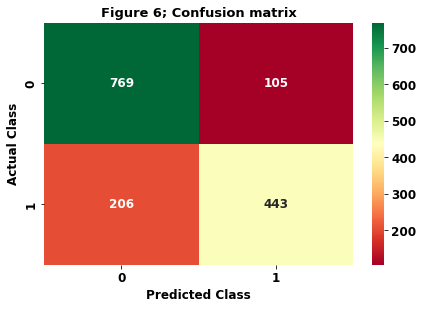

In [23]:
# Visualize the confusion matrix using a heatmap
class_names=[0,1] # Name of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='RdYlGn', fmt='g')
ax.xaxis.set_label_position('bottom')
plt.tight_layout()
plt.title('Figure 6; Confusion matrix', fontsize = 13, weight = 'bold')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

- The confusion matrix table **(cnf_matrix)** was used to evaluate the performance of the classification model. The fundamental of a confusion matrix is the number of correct and incorrect predictions summed up class-wise.


- Diagonal values represent accurate predictions, while non-diagonal elements are inaccurate predictions. In the output, **769 (True Negative)** negative class and **443 (True Positive)** positive class observations were accurately predicted by the model, while **206  (False Negative)** and **105  (False Positive)** observations represent incorrect predictions respectively.

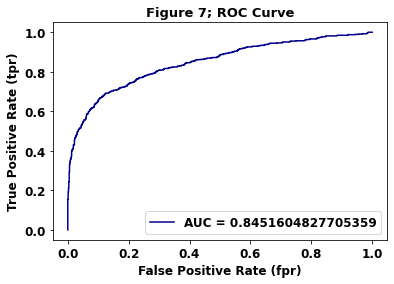

In [24]:
# Fit a Receiver Operating Characteristic (ROC) curve to evaluate the model's performance
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label = 'AUC = ' + str(auc), color = 'darkblue')
plt.title('Figure 7; ROC Curve', fontsize = 13, weight = 'bold')
plt.xlabel('False Positive Rate (fpr)')
plt.ylabel('True Positive Rate (tpr)')
plt.legend(loc = 4)
plt.show();

Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

 - An AUC score of 1.0 represents a perfect classifier. The **AUC score** for this model is **0.85** as shown in **Figure 5**. 

<div class="alert alert-block alert-success">
    The tweets in the <b>testing dataset (test df)</b> can now be predicted using these assessment ratings, as seen below.
    </div>

In [25]:
# Vectorize the text column of the test dataset
test_vectorizer = vectorizer.transform(test_df['text'])

# Check the shape of the vectorixed test dataset
test_vectorizer.shape

(3263, 26918)

In [26]:
# Test predictions
final_pred = logreg.predict(test_vectorizer)
final_pred

array([1, 1, 1, ..., 1, 1, 0])

In [27]:
# Create a new dataframe relfecting the test target predictions made by the fitted logistic regression model
submission_df = pd.DataFrame()
submission_df['id'] = test_df['id']
submission_df['target'] = final_pred
submission_df['target'].value_counts()

0    2139
1    1124
Name: target, dtype: int64

<div class="alert alert-block alert-info">
    The model predicts that <b>2,139</b> test tweets are not real disasters, while <b>1,124</b> tweets are real disasters.
    </div>

## TASK 2 - Feature generation and traditional ML model 🦾

Let's begin preparing our text by eliminating the following types of texts and characters:

- URLs
- HTML tags
- character references
- non-printable characters
- numeric values

After developing a few new features, we'll return to the preprocessing phase.

### Pre-processing Dataset for Task 2

#### Remove URLs

In [28]:
# Create a function to eliminate URLs from text
def remove_url(text):
    text = re.sub(r'((?:https?|ftp|file)://[-\w\d+=&@#/%?~|!:;\.,]*)', '', text)
    return text

# Delete the text's URLs and display the updated training and testing data texts in a new column
train_df['text_cleaned'] = train_df['text'].apply(remove_url)
test_df['text_cleaned'] = test_df['text'].apply(remove_url)

#### Remove HTML Tags

In [29]:
# Create a function to eliminate HTML tags from text
def remove_HTML(text):
    text = re.sub(r'<.*?>', '', text)
    return text

# Delete HTML tags
train_df['text_cleaned'] = train_df['text_cleaned'].apply(remove_HTML)
test_df['text_cleaned'] = test_df['text_cleaned'].apply(remove_HTML)

#### Remove Character References

In [30]:
# Create a function to eliminate character references (e.g., &lt;, &amp;, &nbsp;)
def remove_references(text):
    text = re.sub(r'&[a-zA-Z]+;?', '', text)
    return text

# Delete character references
train_df['text_cleaned'] = train_df['text_cleaned'].apply(remove_references)
test_df['text_cleaned'] = test_df['text_cleaned'].apply(remove_references)

#### Remove Non-printable Characters

In [31]:
# Examine which characters are printable (ASCII)
string.printable

# Create a function to eliminate non-printable characters
def remove_non_printable(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

# Delete non-printable characters
train_df['text_cleaned'] = train_df['text_cleaned'].apply(remove_non_printable)
test_df['text_cleaned'] = test_df['text_cleaned'].apply(remove_non_printable)

#### Remove Numerical Values
Eliminate numeric values, including mixtures of alphabetical characters and numeric values such as 'M194', '5km'.

In [32]:
# Create a function to eliminate numeric values and mixtures
def remove_num(text):
    text = re.sub(r'\w*\d+\w*', '', text)
    return text

# Delete numeric values and mixtures
train_df['text_cleaned'] = train_df['text_cleaned'].apply(remove_num)
test_df['text_cleaned'] = test_df['text_cleaned'].apply(remove_num)

In [33]:
# Examine the results
train_df.head()

,id,keyword,location,text,target,text_len,text_cleaned
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,13,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,22,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,9,", people receive #wildfires evacuation orders in California"
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,17,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school


In [34]:
# Examine the results
test_df.head()

,id,keyword,location,text,text_cleaned
0,0,NaN,NaN,Just happened a terrible car crash,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone.","Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all","there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills in China and Taiwan


- In the second stage of text preprocessing, we will lemmatize, lowercase, and eliminate mentions, stopwords, and punctuation from our text as well as repeated letters in extended words. But first, let's create new combination of variables through feature engineering.

### Feature Engineering ⚙️

The ten features we'll develop are as follows:

- Number of sentences
- Number of words
- Number of characters
- Number of hashtags
- Number of mentions
- Number of all caps words
- Average length of words
- Number of proper nouns (PROPN)
- Number of non-proper nouns (NOUN)
- Percentage of characters that are punctuation

#### Number of Sentences

In [35]:
# Develop a new feature that counts the sentences in each Tweet
train_df['sent_count'] = train_df['text'].apply(nltk.tokenize.sent_tokenize).apply(len)
test_df['sent_count'] = test_df['text'].apply(nltk.tokenize.sent_tokenize).apply(len)

#### Number of Words

In [36]:
# Develop a new feature that counts the words in each Tweet
train_df['word_count'] = train_df['text'].apply(nltk.tokenize.word_tokenize).apply(len)
test_df['word_count'] = test_df['text'].apply(nltk.tokenize.word_tokenize).apply(len)

#### Number of Characters

In [37]:
# Develop a new feature that counts the number of charaters excluding white spaces in each Tweet
train_df['char_count'] = train_df['text'].apply(lambda x: len(x) - x.count(" "))
test_df['char_count'] = test_df['text'].apply(lambda x: len(x) - x.count(" "))

#### Number of Hashtags

In [38]:
# Define a function that returns the number of hashtags in a string
def hash_count(string):
    words = string.split()
    hashtags = [w for w in words if w.startswith('#')]
    return len(hashtags)

# Develop a new feature that counts the number of hashtags in each Tweet
train_df['hash_count'] = train_df['text'].apply(hash_count)
test_df['hash_count'] = test_df['text'].apply(hash_count)

#### Number of Mentions

In [39]:
# Define a function that returns the number of mentions in a string
def ment_count(string):
    words = string.split()
    mentions = [w for w in words if w.startswith('@')]
    return len(mentions)

# Develop a new feature that counts the number of mentions in each Tweet
train_df['ment_count'] = train_df['text'].apply(ment_count)
test_df['ment_count'] = test_df['text'].apply(ment_count)

#### Number of All Caps Words

In [40]:
# Define a function that returns the number of words in all CAPS
def all_caps_count(string):
    words = string.split()
    pattern = re.compile(r'\b[A-Z]+[A-Z]+\b')
    capsWords = [w for w in words if w in re.findall(pattern, string)]
    return len(capsWords)

# Develop a new feature that counts the number of words in all CAPS
train_df['all_caps_count'] = train_df['text'].apply(all_caps_count)
test_df['all_caps_count'] = test_df['text'].apply(all_caps_count)

#### Average Length of Words

In [41]:
# Define a function that returns the average length of words
def avg_word_len(string):
    words = string.split()
    total_len = sum([len(words[i]) for i in range(len(words))])
    avg_len = round(total_len / len(words), 2)
    return avg_len

# Develop a new feature for the average length of words
train_df['avg_word_len'] = train_df['text'].apply(avg_word_len)
test_df['avg_word_len'] = test_df['text'].apply(avg_word_len)

#### Number of Proper Nouns (PROPN)

In [42]:
# Define a function using nltk that returns the number of proper nouns in the text
def propn_count_nltk(text):    
    tokens = nltk.word_tokenize(text)
    tagged = [token for token in nltk.pos_tag(tokens)]
    propn_count = len([token for (token, tag) in tagged if tag == 'NNP' or tag == 'NNPS'])
    return propn_count

# Develop a new feature for the number of proper nouns
train_df['propn_count_nltk'] = train_df['text'].apply(propn_count_nltk)
test_df['propn_count_nltk'] = test_df['text'].apply(propn_count_nltk)

In [43]:
# Examine the results
train_df[['id', 'text', 'text_cleaned', 'propn_count_nltk']].head()

,id,text,text_cleaned,propn_count_nltk
0,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,4
1,4,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask. Canada,5
2,5,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,0
3,6,"13,000 people receive #wildfires evacuation orders in California",", people receive #wildfires evacuation orders in California",1
4,7,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,2


#### Number of Non-Proper Nouns (NOUN)

In [44]:
# Define a function using nltk that returns the number of non-proper nouns in the text
def noun_count_nltk(text):    
    tokens = nltk.word_tokenize(text)
    tagged = [token for token in nltk.pos_tag(tokens)]
    noun_count = len([token for (token, tag) in tagged if tag != 'NNP' or tag != 'NNPS'])
    return noun_count

# Develop a new feature for the number of proper nouns
train_df['noun_count_nltk'] = train_df['text'].apply(noun_count_nltk)
test_df['noun_count_nltk'] = test_df['text'].apply(noun_count_nltk)

#### Percentage of characters that are punctuation

In [45]:
# Define a function that returns the percentage of punctuation
def punc_per(text):
    total_count = len(text) - text.count(" ")
    punc_count = sum([1 for c in text if c in string.punctuation])
    if punc_count != 0 and total_count != 0:
        return round(punc_count / total_count * 100, 2)
    else:
        return 0

# Develop a new faeture for the percentage of punctuation in text
train_df['punc_per'] = train_df['text'].apply(punc_per)
test_df['punc_per'] = test_df['text'].apply(punc_per)

In [46]:
# Examine the results
train_df.head()

,id,keyword,location,text,target,text_len,text_cleaned,sent_count,word_count,char_count,hash_count,ment_count,all_caps_count,avg_word_len,propn_count_nltk,noun_count_nltk,punc_per
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,13,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,14,57,1,0,1,4.38,4,14,1.75
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,Forest fire near La Ronge Sask. Canada,2,8,32,0,0,0,4.57,5,8,3.12
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,22,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,2,24,112,0,0,0,5.09,0,24,2.68
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,9,", people receive #wildfires evacuation orders in California",1,9,57,1,0,0,7.12,1,9,3.51
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,17,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,18,72,2,0,0,4.50,2,18,2.78


In [47]:
# Examine the results
test_df.tail()

,id,keyword,location,text,text_cleaned,sent_count,word_count,char_count,hash_count,ment_count,all_caps_count,avg_word_len,propn_count_nltk,noun_count_nltk,punc_per
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn,EARTHQUAKE SAFETY LOS ANGELES SAFETY FASTENERS XrWn,1,8,48,0,0,6,6.00,8,8,0.00
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power,Storm in RI worse than last hurricane. My hardest hit. My yard looks like it was bombed. Around still without power,4,30,117,0,0,1,5.09,2,30,4.27
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/UtbXLcBIuY,Green Line derailment in Chicago,1,8,50,0,0,0,8.33,2,8,10.00
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3,MEG issues Hazardous Weather Outlook (HWO),1,11,59,0,0,1,8.43,5,11,11.86
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Emergency Plan. #yycstorm,#CityofCalgary has activated its Municipal Emergency Plan. #yycstorm,2,11,61,2,0,0,7.62,4,11,4.92


### Pre-processing Dataset (Continuation) for Task 2

Resuming our text preprocessing, let's lemmatize the text and convert it to lowercase. In addition, we'll eliminate mentions, stopwords, and punctuation from words that have been lengthened. We'll continue to use hashtags because they could be really useful for this particular project.

#### Lemmatization

In [48]:
# Define a function for lemmatizing the text
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [49]:
# Lemmatize the text
train_df['text_cleaned'] = train_df['text_cleaned'].apply(stemm_text)
test_df['text_cleaned'] = test_df['text_cleaned'].apply(stemm_text)

#### Convert the text to lower case

In [50]:
# Convert the text to lowercase
train_df['text_cleaned'] = [t.lower() for t in train_df['text_cleaned']]
test_df['text_cleaned'] = [t.lower() for t in test_df['text_cleaned']]

#### Remove Repeated Charcters in Elongated Words

In [51]:
# Define a function that eliminates repeated characters from long words.
def remove_repeated(text):
    elongated = re.compile(r'(\S*?)([a-z])\2{2,}')
    text = elongated.sub(r'\1\2', text)
    return text

# Eliminate repeated characters in long words
train_df['text_cleaned'] = train_df['text_cleaned'].apply(remove_repeated)
test_df['text_cleaned'] = test_df['text_cleaned'].apply(remove_repeated)

#### Remove Mentions

In [52]:
# Define a function that eliminates mentions
def remove_mention(text):
    text = re.sub(r'@\w+', '', text)
    return text

# Eliminate mentions
train_df['text_cleaned'] = train_df['text_cleaned'].apply(remove_mention)
test_df['text_cleaned'] = test_df['text_cleaned'].apply(remove_mention)

#### Remove Stopwords

In [53]:
# Define a function that eliminates stopwords
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

# Eliminate stopwords
train_df['text_cleaned'] = train_df['text_cleaned'].apply(remove_stopwords)
test_df['text_cleaned'] = test_df['text_cleaned'].apply(remove_stopwords)

#### Remove Punctuation

In [54]:
# Define a function to eliminate punctuation
def remove_punct(text):
    punct = string.punctuation
    text_nospunct = ' '.join([token for token in text.split() if token not in punct])
    return text_nospunct

# Eliminate punctuation
train_df['text_cleaned'] = train_df['text_cleaned'].apply(remove_punct)
test_df['text_cleaned'] = test_df['text_cleaned'].apply(remove_punct)

In [55]:
# Examine the results
train_df[['id', 'text', 'text_cleaned']].head()

,id,text,text_cleaned
0,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,deed reason #earthquak may allah forgiv us
1,4,Forest fire near La Ronge Sask. Canada,forest fire near la rong sask. canada
2,5,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,resid ask shelter place notifi officers. evacu shelter place order expect
3,6,"13,000 people receive #wildfires evacuation orders in California",peopl receiv #wildfir evacu order california
4,7,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,got sent photo rubi #alaska smoke #wildfir pour school


In [56]:
# Examine the results
test_df[['id', 'text', 'text_cleaned']].head()

,id,text,text_cleaned
0,0,Just happened a terrible car crash,happen terribl car crash
1,2,"Heard about #earthquake is different cities, stay safe everyone.","heard #earthquak differ cities, stay safe everyone."
2,3,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all","forest fire spot pond, gees flee across street, cannot save"
3,9,Apocalypse lighting. #Spokane #wildfires,apocalyps lighting. #spokan #wildfir
4,11,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan


### Raw vs. Preprocessed Text with Word Clouds

In [57]:
# Create a word cloud for disaster and non-disaster to compare the raw and preprocessed tweets
# Concatenate all the preprocessed text for both labels
non_disaster_processed = [''.join(t) for t in train_df[train_df['target']==0]['text_cleaned']]
non_disaster_processed_s = ' '.join(map(str, non_disaster_processed))
disaster_processed = [''.join(t) for t in train_df[train_df['target']==1]['text_cleaned']]
disaster_processed_s = ' '.join(map(str, disaster_processed))

# Generate word clouds of the preprocessed text
non_disaster_processed_wc = WordCloud(width=800, height=400, max_words=500, background_color='white', 
                                      random_state=random_state).generate(non_disaster_processed_s)
disaster_processed_wc = WordCloud(width=800, height=400, max_words=500, 
                                  random_state=random_state).generate(disaster_processed_s)

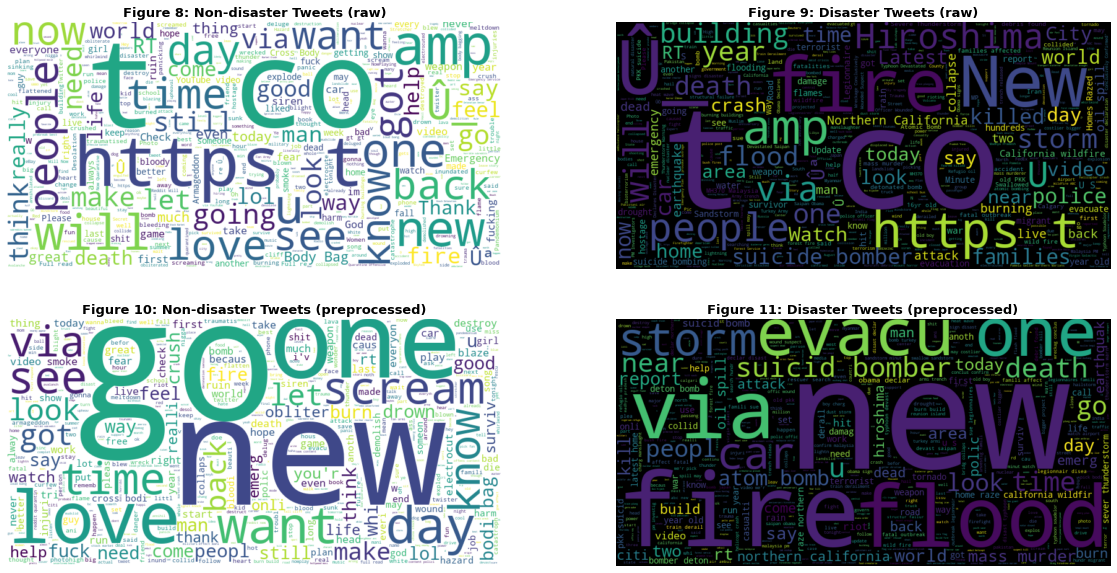

In [58]:
# Create subplots for the generated clouds
fig, axes = plt.subplots(2, 2, figsize = (20,10))
axes[0,0].imshow(non_disaster_cloud, interpolation='bilinear')
axes[0,1].imshow(disaster_cloud, interpolation='bilinear')
axes[1,0].imshow(non_disaster_processed_wc, interpolation='bilinear')
axes[1,1].imshow(disaster_processed_wc, interpolation='bilinear')

# Turn the axis off
[ax.axis('off') for ax in axes.ravel()]

# Add titles
axes[0,0].set_title('Figure 8: Non-disaster Tweets (raw)', fontsize = 13, weight = 'bold')
axes[0,1].set_title('Figure 9: Disaster Tweets (raw)', fontsize = 13, weight = 'bold')
axes[1,0].set_title('Figure 10: Non-disaster Tweets (preprocessed)', fontsize = 13, weight = 'bold')
axes[1,1].set_title('Figure 11: Disaster Tweets (preprocessed)', fontsize = 13, weight = 'bold')

# Show the figure
plt.show();

- The terms that are used frequently but have actual meaning are now easier to see. On the word cloud created from Tweets about actual disasters, it appears that more words related to disasters are appearing.

### Visualizing the Difference 📈
See if there are any distinguishable differences between disaster and non-disaster tweets in our training dataset by exploring some of the features we've developed.

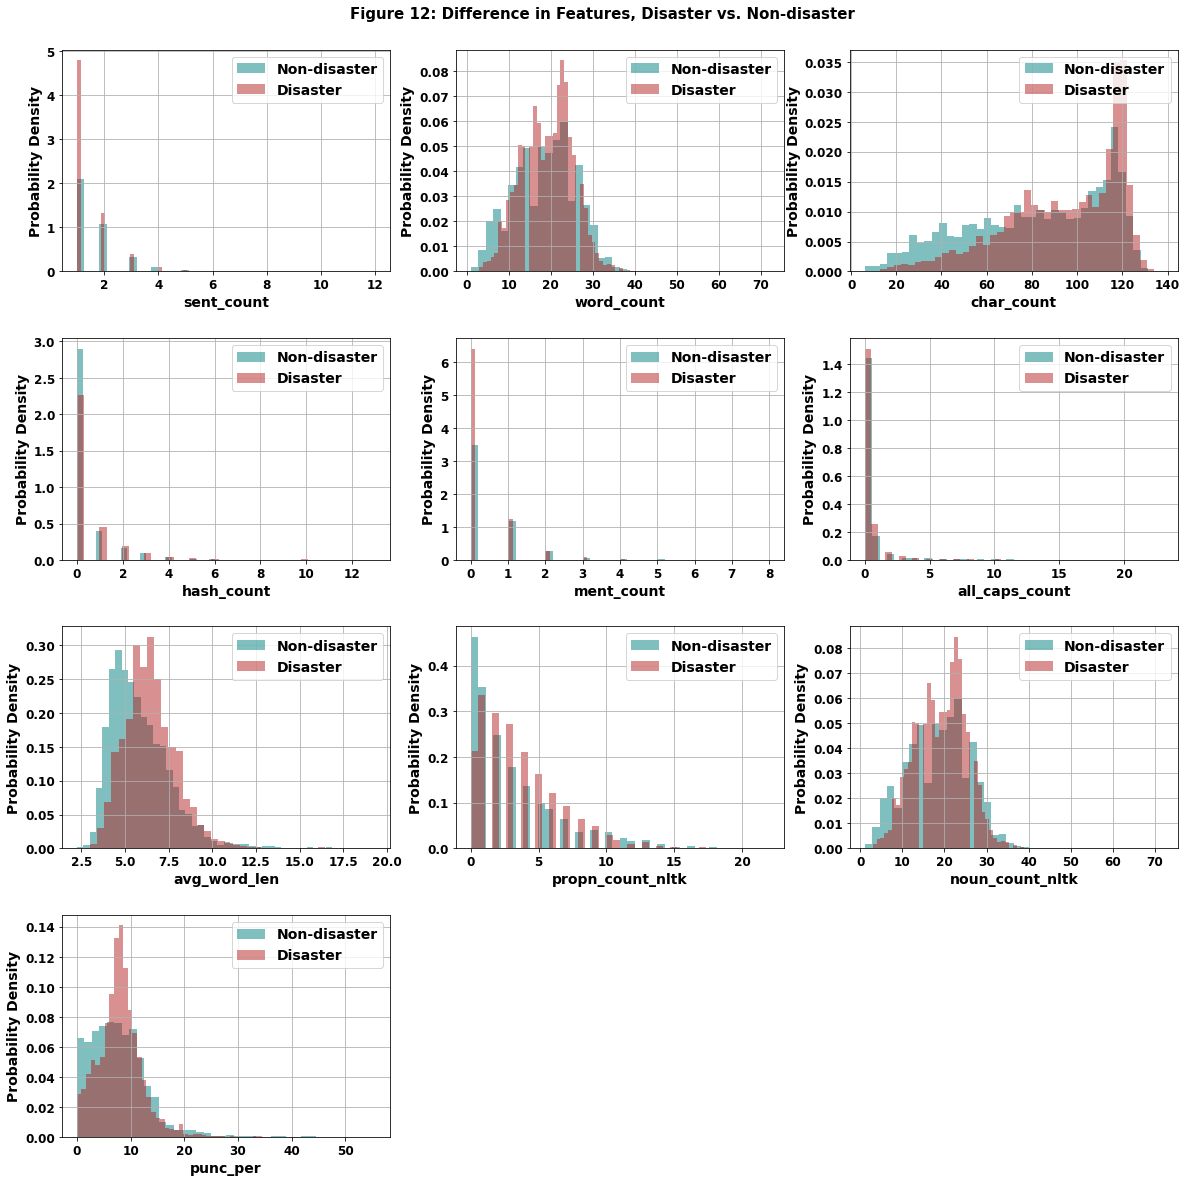

In [59]:
# Specify the features' names in variables.
features = ['sent_count', 'word_count', 'char_count', 'hash_count', 'ment_count', 'all_caps_count', 
            'avg_word_len', 'propn_count_nltk', 'noun_count_nltk', 'punc_per']

# Create the figure
fig = plt.figure(figsize = (20, 20))

# Adjust the height of the padding between subplots to avoid overlapping
plt.subplots_adjust(hspace = 0.3)

# Add a centered suptitle to the figure
plt.suptitle("Figure 12: Difference in Features, Disaster vs. Non-disaster", fontsize = 15, weight = 'bold', y = 0.91)

# Generate the histograms in a for loop
for i, feature in enumerate(features):
    
    # Add a new subplot iteratively
    ax = plt.subplot(4, 3, i+1)
    ax = train_df[train_df['target'] == 0][feature].hist(alpha = 0.5, label = 'Non-disaster', bins = 40, color = 'teal', density = True)
    ax = train_df[train_df['target'] == 1][feature].hist(alpha = 0.5, label = 'Disaster', bins = 40, color = 'firebrick', density = True)
    
    # Set x_label, y_label, and legend
    ax.set_xlabel(features[i], fontsize = 14)
    ax.set_ylabel('Probability Density', fontsize = 14)
    ax.legend(loc='upper right', fontsize = 14)
    

# Show the figure
plt.show();

- **Word_count, char_count, avg_word_len, noun_count_nltk, and punc_per** are the five features we'll utilise for our models because they exhibit greater distributional variation than the other features we've developed.
- **Note:** Due to the differing sizes of disaster- and non-disaster-related Tweets, the y-axis in the charts above indicates probability density rather than the number of tweets.

Let's proceed to model creation!

### Model Development 🏗️

In [60]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer()

# Fit and transform
X_tfidf = tfidf.fit_transform(train_df['text_cleaned'])

In [61]:
# Create a dataframe from the sparse matrix
X_tfidf_df = pd.DataFrame(X_tfidf.toarray())

# Examine the dataframe
X_tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,12265,12266,12267,12268,12269,12270,12271,12272,12273,12274
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
# Obtain the feature names from our stored vectorizer and assign them to X_tfidf_df
# To avoid getting 'FutureWarning: Feature names only support names that are strings.'
X_tfidf_df.columns = tfidf.get_feature_names_out()

# Examine the column names
X_tfidf_df.columns

Index(['__', '_on', '_t', 'a_', 'aa', 'aan', 'aand', 'aar', 'aashiqui', 'ab',
       ...
       'zon', 'zone', 'zones', 'zoom', 'zotar', 'zouma', 'zrnf', 'zss',
       'zumiez', 'zurich'],
      dtype='object', length=12275)

In [63]:
# Create the new dataframe, X_features
X_features = pd.concat([train_df[['word_count', 'char_count', 'avg_word_len', 'noun_count_nltk', 'punc_per']],
                        X_tfidf_df], axis=1)

# Examine the shape
X_features.shape

(7613, 12280)

In [64]:
# Examine the dataframe
X_features.head()

,word_count,char_count,avg_word_len,noun_count_nltk,punc_per,__,_on,_t,a_,aa,...,zon,zone,zones,zoom,zotar,zouma,zrnf,zss,zumiez,zurich
0,14,57,4.38,14,1.75,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8,32,4.57,8,3.12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,24,112,5.09,24,2.68,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,57,7.12,9,3.51,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18,72,4.50,18,2.78,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Training the model

In [65]:
# Split the cleaned and transformed dataset into training and testing sets using the 80:20 ratio
# Select the input/output
X = X_features
y = train_df['target']

# Split the data
# The names, X_val and y_val, are used instead of X_test and y_test to avoid confusion with our actual test data
# which we will be using to make the predictions with the selected model at the end of this notebook
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 42)

<div class="alert alert-block alert-info">
    The study opted to use the <b>Random Forest classification model</b> for Task 2, a popularly used non-neural network NLP classification model. A random forest is a meta estimator that employs averaging to increase predicted accuracy and reduce over-fitting after fitting numerous decision tree classifiers to distinct dataset sub-samples. The maximum samples option regulates the sub-sample size; otherwise, each tree is constructed using the entire dataset. Every decision tree in the random forest returns a class forecast, and the classification with the highest number of votes becomes the model's prediction.
    <div>

In [66]:
# Defining the modelling function
def modeling2(alg, alg_name, params={}):
    model = alg(**params) # Instantiating the algorithm class and unpacking parameters if any
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    # Performance evaluation
    def print_scores(alg, y_true, y_pred):
        print('\033[1m' + alg_name + '\033[0m')
        acc_score = accuracy_score(y_true, y_pred)
        print("accuracy: ",acc_score)
        pre_score = precision_score(y_true, y_pred)
        print("precision: ",pre_score)
        rec_score = recall_score(y_true, y_pred)                            
        print("recall: ",rec_score)
        f_score = f1_score(y_true, y_pred, average='weighted')
        print("f1_score: ",f_score)

    print_scores(alg, y_val, y_pred)
    return model

# Applying the Random Forest machine learning algorithms
rf_model = modeling2(RandomForestClassifier, "Random Forest Classification")

Random Forest Classification
accuracy:  0.7925147734734077
precision:  0.8741573033707866
recall:  0.5993836671802774
f1_score:  0.7840116692252447


- The random forest classification model predicts the class of tweets with an **accuracy** of **79.25%**. This may be considered a fair accuracy score.
 - The model accurately predicts accurate disaster tweets **87.42%** of the time based on the **Precision score**.
 - The model correctly identifies observations of a certain class correctly from all of the given examples of that class **59.94%** of the time based on the **Recall score**..
 - If there are positive observations in the test set, the classification model can identify them **78.40%** of the time based on the **F1-Score**.

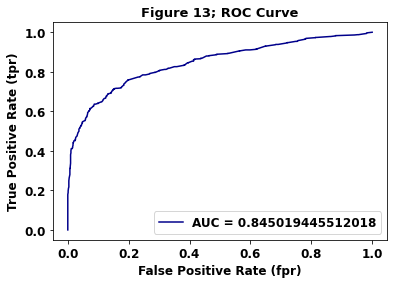

In [67]:
# Fit a Receiver Operating Characteristic (ROC) curve to evaluate the model's performance
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_proba = rf.predict_proba(X_val)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_val, y_pred_proba)
auc = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr, tpr, label = 'AUC = ' + str(auc), color = 'darkblue')
plt.title('Figure 13; ROC Curve', fontsize = 13, weight = 'bold')
plt.xlabel('False Positive Rate (fpr)')
plt.ylabel('True Positive Rate (tpr)')
plt.legend(loc = 4)
plt.show();

- The **AUC score** for this model is **0.85** as shown in **Figure 13**. 

<div class="alert alert-block alert-success">
    The tweets in the <b>testing dataset (test df)</b> can now be predicted using these evaluation ratings, as seen below.
    </div>

In [68]:
# Fit the cleaned text to the vectorizer
tfidf_vect_fit = tfidf.fit(train_df['text_cleaned'])

# Create the vectorized columns
tfidf_train = tfidf_vect_fit.transform(train_df['text_cleaned'])
tfidf_test = tfidf_vect_fit.transform(test_df['text_cleaned'])

In [69]:
# Create dataframes from the sparse matrices
tfidf_train_df = pd.DataFrame(tfidf_train.toarray())
tfidf_test_df = pd.DataFrame(tfidf_test.toarray())

# Obtain the feature names from our stored vectorizers and assign them to tfidf_train_df and tfidf_test_df
# to avoid getting 'FutureWarning: Feature names only support names that are strings.'
tfidf_train_df.columns = tfidf.get_feature_names()
tfidf_test_df.columns = tfidf.get_feature_names()

In [70]:
# Concatenate back the vectorized data and the 4 features we've created
X_train_vect = pd.concat([train_df[['word_count', 'char_count', 'avg_word_len', 'noun_count_nltk', 'punc_per']].reset_index(drop=True),
                          tfidf_train_df], axis=1)
X_test_vect = pd.concat([test_df[['word_count', 'char_count', 'avg_word_len', 'noun_count_nltk', 'punc_per']].reset_index(drop=True),
                         tfidf_test_df], axis=1)

# Store the labels
y_train = train_df['target']

# Examine the shape
print(X_train_vect.shape, X_test_vect.shape)

(7613, 12280) (3263, 12280)


In [71]:
# Fit the model and check the processing time
start = time()
final_model_fit = rf.fit(X_train_vect, y_train)
end = time()
fit_time = end - start

# Make predictions and examine the processing time
start = time()
final_pred = rf.predict(X_test_vect)
end = time()
pred_time = end - start

print('Fit time: {} secs | Predict time: {} secs'.format(round(fit_time, 2), round(pred_time, 2)))

Fit time: 20.91 secs | Predict time: 0.36 secs


In [72]:
# Create a new dataframe relfecting the test target predictions made by the fitted random forest model
submission = test_df[['id']].reset_index(drop=True)
submission['target'] = final_pred.astype('int64')
submission

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


## TASK 3 - Pre-trained word embeddings + linear classifier model 🦮

### GloVe for Vectorization

To represent our words in this case, we'll utilise the GloVe pretrained corpus model. There are three different types: 50D, 100D, and 200 Dimensional. Here, we'll try 100 D.

In [73]:
# Define a function to create a new dataframe
def create_corpus(train_df):
    corpus = []
    for tweet in tqdm(train_df['text']):
        words = [word.lower() for word in word_tokenize(tweet) if((word.isalpha() == 1) & (word not in stop_words))]
        corpus.append(words)
    return corpus
    
corpus = create_corpus(train_df)

100%|██████████| 7613/7613 [00:00<00:00, 9337.99it/s]


In [74]:
# Select any pre-trained word embedding of your choice
# Create word embedding dictionary (GloVe)
embedding_dict = {}
with open('glove.6B.100d.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embedding_dict[word] = vectors
f.close()

In [75]:
# Run text inputs through the word embedding to map each input instance
MAX_LEN = 50
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences = tokenizer_obj.texts_to_sequences(corpus)

tweet_pad = pad_sequences(sequences, maxlen = MAX_LEN, truncating = 'post', padding = 'post')
word_index = tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 15045


In [76]:
# Running text inputs through the word embedding to map each input instance
num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec = embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec

100%|██████████| 15045/15045 [00:00<00:00, 444708.90it/s]


### Training the Model

<div class="alert alert-block alert-info">
    The study opted to use the <b>Linear model SDGClassifier</b> for Task 3. The loss gradient is computed for each sample in this estimator's implementation of regularised linear models with stochastic gradient descent (SGD) learning, and the model is updated along the way with a decreasing strength schedule (aka learning rate). The partial fit method in SGD enables minibatch (online/out-of-core) learning. The data should have zero mean and unit variance for optimum results when using the default learning rate schedule.
    <div>

In [77]:
# Training a sequential model
model = Sequential()

embedding = Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(1, activation = 'sigmoid'))

optimzer = Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-12-03 15:26:19.265708: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-03 15:26:19.266149: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [78]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           1504600   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,546,905
Trainable params: 42,305
Non-trainable params: 1,504,600
_________________________________________________________________


In [79]:
# Split the cleaned and transformed dataset into training and testing sets using the 80:20 ratio
# Select the input/output
train = tweet_pad[:train_df.shape[0]]
test = tweet_pad[train_df.shape[0]:]

X_train, X_test, y_train, y_test = train_test_split(train, train_df['target'].values,test_size = 0.20)
print('Shape of train', X_train.shape)
print('Shape of Validation', X_test.shape)

Shape of train (6090, 50)
Shape of Validation (1523, 50)


In [80]:
# Train a simple linear model using sklearn.linear_model.SGDClassifier
text_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss = 'hinge', penalty = 'l2',
                          alpha = 1e-3, random_state = 42,
                          max_iter = 5, tol = None))])
                        
X = train_df.text
y = train_df.target

# Split the cleaned and transformed dataset into training and testing sets using the 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

text_clf.fit(X, y)
y_pred = text_clf.predict(X_test)
np.mean(y_pred == y_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.98      0.86       874
           1       0.95      0.60      0.74       649

    accuracy                           0.82      1523
   macro avg       0.86      0.79      0.80      1523
weighted avg       0.84      0.82      0.81      1523



- The SDGClassification model predicts the class of tweets with an **accuracy** of **82%**.

In [81]:
# Create a new dataframe reflecting the test target predictions made by the fitted SGDClassifier model
X_submit = test_df.text
y_submit = text_clf.predict(X_submit)
submission_df = pd.DataFrame({'id':test_df.id, 'target':y_submit})
submission_df

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,0
3259,10865,0
3260,10868,1
3261,10874,1


## TASK 4 - Recommendations to Clients 💻

This study used three distinct machine learning binary classifications with varied degrees of complexity to categorise natural disasters (real or not) based on labelled tweets. For this research, three models were taken into consideration:

- Logistic Regression Model
- Random Forest Classification Model
- Linear Classification model with Stochastic Gradient Descent (SGD) Training

These three models required different amounts of data processing, which produced accuracy scores that weren't too dissimilar. However, the model fit with the Linear Classification model with Stochastic Gradient Descent (SGD) Training had the highest accuracy score of **82%** but required more processing time than the other models. Only the terms in the text variable that were disaster-related were taken into account by the Bag of Words model fit using the Logistic Regression Classifier. Since 99% of tweets contain a disaster-related keyword and the positive and negative classes are equally balanced (at least in our training set), this method can be implemented in the shortest amount of time. Nevertheless, it is obvious that this study will not benefit significantly from simply noting the presence or absence of keywords.

In conclusion, the Random Forest Classifier classification model incorporates newly developed variables such as the number of words, characters, hashtags, mentions, sentences, all-caps words, punctuations, proper and non-proper nouns, and the percentage of characters that are punctuation in each tweet that were extracted from the tweets variable in the training data. A prediction accuracy score of about **79%** was obtained using the fitted Random Forest Classification model when taking into account the five most reliable variables based on their distribution. Of the three fitted models, this one accounts for the most crucial dataset variables and is by far the most balanced in terms of difficulty, resource, and time complexity.

#### Future Exploration

In this notebook, we've explored a limited number of algorithms, methodologies, and models. In practice, it is not uncommon to test over hundreds or even higher number of models. Some other ways that would help us find the best model to solve the given NLP problem include:

- Using different vectorizers (e.g., Word2Vec, N-grams)
- Exploring the accuracy of the proper and improper nouns variables created in **Task 2** using the nltk library, considering alternatives such as spaCy, an open-source software library for advanced natural language processing, written in the programming languages Python and Cython.
- Including parts of the text we removed from the modelling (e.g., stopwords)
- Exploring different hyperparameter settings within each algorithm (e.g., adding 'max_features' parameter and a few possible values of it to the RandomizedSearchCV object)
- Using different hyperparameter optimization methods (e.g., Bayesian method using Optuna)